This notebook is intended to introduce and demonstrate some of the features of pyMAISE and examine the performance of machine learning models on a common nuclear engineering application. For further information on the capabilities of the classes and functions shown in this notebook, please refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# MIT Reactor

**Inputs**: Control rod heights ($cm$)

**Outputs**: Pin power ($W$)

The MIT reactor data set represents the institution’s light-water-cooled 6 MW thermal power reactor. The figure below shows the core contains 22 fuel elements, 5 locations for in-core experiments, with 6 control blades surrounding them. The data set is used to find a relationship between the 6 control blade heights and the power produced by the 22 fuel elements in the core. Therefore, the data set is constructed by perturbing the depths of the control blades in the reactor. The corresponding output results in the power levels for each of the 22 fuel elements. The data was generated using MCNP and the data set size includes 1000 simulations/samples [[RPS+23]](https://pymaise.readthedocs.io/en/stable/index.html#id3). The goal is to use pyMAISE to build, tune, and compare various ML models' performance in predicting the core power distribution based on the control blade insertion depth.

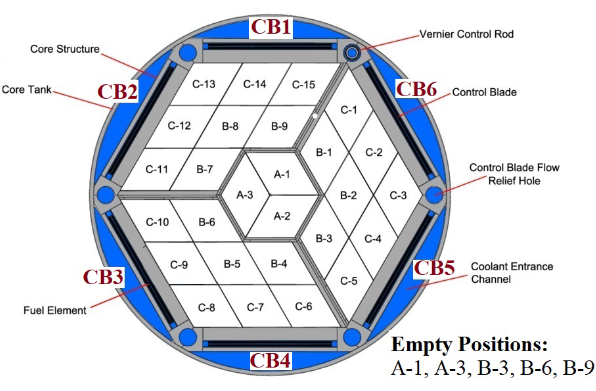

The following are a few common packages and functions that will prove useful while using pyMAISE. 

In [19]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

For machine learning tuning and analysis with pyMAISE we need to import several functions and classes. Firstly we need the MITR data set which we can get using `pyMAISE.datasets.load_MITR`. We will need to split the data into training/testing data and scale it. For this we use the `pyMAISE.preprocessing` python module. The remaining classes we can get from `pyMAISE` directly for which we import as `mai` for convenience.

In [5]:
from pyMAISE.datasets import load_MITR
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

## pyMAISE Initialization

Starting any pyMAISE job requires initialization, this includes the definition of global settings used throughout pyMAISE. These settings and their defaults include:

- `problem_type`: the problem type, either regression or classification, defined by `pyMAISE.ProblemType`,
- `verbosity=0`: the level of output from pyMAISE,
- `random_state=None`: the seed for the random number generator which can be used to get reproducible results from pyMAISE,
- `num_configs_saved=5`: the number of top hyperparameter configurations for each model evaluated during tuning,
- `new_nn_architecture=True`: a boolean that dictates whether to use the old depricated pyMAISE neural network tuning architecture,
- `cuda_visible_devices=None`: sets the `CUDA_VISIBLE_DEVICES` environment variable.

The only argument that needs to be specified is `problem_type`. We also pass `"-1"` to `cuda_visible_devices` to ensure we only use tensorflow on the CPU. This is useful for this problem since we will be building rather simple dense feedforward neural networks with a fairly small data set. Therefore, running tensorflow on a GPU may hurt our performance. We leave the others default giving us 5 hyperparameter configurations for each model, keeping the stochastic nature of some of the algorithms, and using the current neural network hyperparameter tuning architecture.

In [6]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

## Data Loading and Preprocessing

pyMAISE comes with several benchmarked data sets such as this MIT reactor data set. Each data set has an accompanied load function. Most load functions return three `xarray.DataArrays`: the raw data, input data, and output data. You can load personal data using the `pyMAISE.preprocessing.read_csv` function. Refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html) for specifics on the use of this function. Loading the MIT reactor data gives the following data:

In [7]:
data, inputs, outputs = load_MITR()

The MIT reactor data set has 6 inputs; one for each control rod position:

In [8]:
inputs

<xarray.DataArray (index: 1000, variable: 6)>
array([[25.95991738, 22.94937226, 20.85317495, 24.66916763, 20.48104739,
        25.35726597],
       [21.75386762, 25.3606259 , 20.58853009, 20.11087249, 27.46711019,
        25.81658492],
       [27.42919944, 23.5701803 , 27.59630663, 26.39044508, 23.99603712,
        24.61182164],
       ...,
       [24.47247392, 23.21393049, 21.36224456, 25.72137934, 21.72606189,
        20.486756  ],
       [25.14502476, 25.88719097, 22.63841745, 23.11818585, 27.13820033,
        20.12257523],
       [20.80736327, 20.47244047, 26.3283514 , 24.93870275, 22.13608868,
        20.23749172]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'CR1' 'CR2' 'CR3' 'CR4' 'CR5' 'CR6'

and 22 fuel element power outputs:

In [9]:
outputs

<xarray.DataArray (index: 1000, variable: 22)>
array([[25930.9161377 , 22958.31494141, 21725.51635742, ...,
        17912.01452637, 18207.04260254, 19089.96942139],
       [25883.078125  , 22856.06195068, 21602.10876465, ...,
        18699.55557251, 18381.29052734, 19052.58782959],
       [25672.20825195, 22584.91094971, 21419.95025635, ...,
        17878.91418457, 17831.21044922, 18702.88995361],
       ...,
       [26011.28759766, 22868.43511963, 21718.16387939, ...,
        17537.16012573, 17521.70654297, 18469.28430176],
       [25867.42346191, 22746.65338135, 21650.78973389, ...,
        17898.8989563 , 17467.56048584, 18369.0256958 ],
       [26047.4777832 , 22729.4630127 , 21553.59606934, ...,
        17622.36529541, 17503.63659668, 18324.41955566]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'A-2' 'B-1' 'B-2' 'B-4' ... 'C-13' 'C-14' 'C-15'

To get a better understanding of this data set lets plot a correlation matrix of the data using `pyMAISE.preprocessing.correlation_matrix`.

(<Figure size 800x800 with 2 Axes>, <Axes: >)

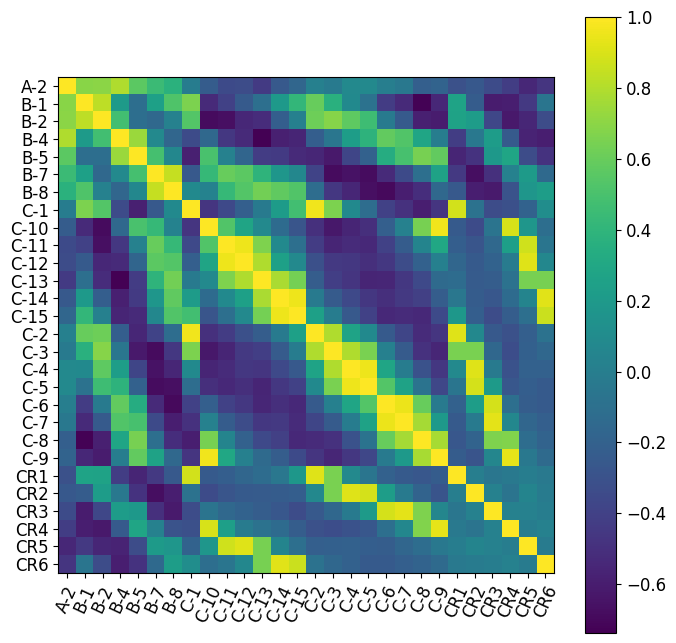

In [10]:
correlation_matrix(data)

There is a negative correlation between the control rod positions and the inner fuel elements (A and B elements).

With the data loaded, we can now preprocess it. This includes splitting into training and testing data sets, and scaling. For splitting we use the `pyMAISE.preprocessing.train_test_split` function and define the fraction of data for testing using `test_size`. On MITR we take 30% of the data for testing. The result is a tuple of data: `(xtrain, xtest, ytrain, ytest)`. We can then scale this data using `pyMAISE.preprocessing.scale_data` with any object that supports `fit_transform` and `transform` functions. Common scalers include [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) and [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler). Many machine learning models learn best with scaled data. For this data set, we use min-max scaling on both the input and output data. `pyMAISE.preprocessing.scale_data` returns the scaled data and the scaler fit to the data. These scalers are used in postprocessing to evaluate the preformance of the models.

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

For model initialization and tuning we use the `pyMAISE.Tuner`. pyMAISE supports both classical ML methods with [scikit-learn](https://scikit-learn.org/stable/index.html) and sequential neural networks with [Keras](https://keras.io/). We strongly recommend you refer to `pyMAISE.Tuner` in the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html) for a list of supported models, neural network layers, and other information crucial for optimal tuning. Using a dictionary, we can define all the models we wish to hyperparameter tune. For the MITR data set we define the following regression models with their dictionary keys:

- linear: `"Linear"`,
- lasso: `"Lasso"`,
- decision tree: `"DT"`,
- random forest: `"RF"`,
- k-nearest neighbors: `"KN"`,
- feed forward neural network: `"FNN"`.

pyMAISE uses the dictionary keys for classical models to determine which [scikit-learn](https://scikit-learn.org/stable/index.html) model you request. If the keys do not match any of the supported keys then it is assumed to be a neural network. In the `"models"` key we define these models in a list. For classical models we can then define the hyperparameters which will remain constant throughout tuning. These parameters only need to be defined if you want something different then default. Refer to the models documentation in [scikit-learn](https://scikit-learn.org/stable/index.html) for hyperparameters and defaults.

For the neural network model, we need to define the architecture, optimizer, compiling, and fitting parameters under the `"structural_params"`, `"optimizer"`, `"compile_params"`, and `"fitting_params"` keys. These parameters include those that remain constant and change during tuning. To define hyperparameters for tuning we use the `pyMAISE.Int`, `pyMAISE.Float`, `pyMAISE.Choice`, `pyMAISE.Boolean`, and `pyMAISE.Fixed` classes. These classes are wrappers for [KerasTuner](https://keras.io/keras_tuner/). 

To define the model architecture, we use the supported Keras layers defined in the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html) under the `pyMAISE.Tuner`. These layers must be different in name but must use the base layer name. Within the layers, pyMAISE supports additional hyperparameters which include `"sublayer"`, `"wrapper"`, and `"num_layers"` to define sublayers, wrappers (such as [keras.layers.TimeDistributed](https://keras.io/api/layers/recurrent_layers/time_distributed/)), and the number of layers.

We can then pass all this information to `pyMAISE.Tuner`.

In [12]:
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

Hyperparameter tuning is split into two options: classical model and neural network tuning. For the classical models, pyMAISE supports grid, random, and Bayesian search. For the neural network models, pyMAISE supports grid, random, Bayesian, and hyperband search. All search methods use cross validation.

We define the hyperparameter search space for the classical models by defining the arrays, distributions, or [skopt.space.space](https://scikit-optimize.github.io/stable/modules/classes.html#module-skopt.space.space) for each hyperparameter we plan to tune. We define these within subdictionaries within the model keys. For MITR we use `pyMAISE.Tuner.random_search` with 200 iterations as the data set is fairly small and the classical models are computationally cheap. For these models we define the search space using [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

We do not hyperparameter tune linear regression because the hyperparameter options are limited and the default scikit-learn model performs well on linear problems.

Since we have already defined the feed forward neural network search space in the previous section, all we need to do is call the search method function. For these NNs we can call `pyMAISE.Tuner.nn_bayesian_search` with 50 iterations as NNs tend to be more computationally expensive to train over the classical models and the Bayesian optimization may converge on the optimal model for fewer iterations.

We set `cv` for both methods to 5 which gives us 5 cross validation splits for each model. This will avoid overfitting. Therefore, for each classical model we run 1000 hyperparameter configurations and for the neural networks we run 250 hyperparameter configurations.

In [13]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 00m 19s]
r2_score: 0.9872738970335829

Best r2_score So Far: 0.9968829353579401
Total elapsed time: 00h 11m 21s
Hyperparameter tuning took 37.47577362457911 minutes to process.


With the conclusion of training we can see training results for each iteration using the `pyMAISE.Tuner.convergence_plot` function. For the neural networks we have the following: 

(0.0, 1.0)

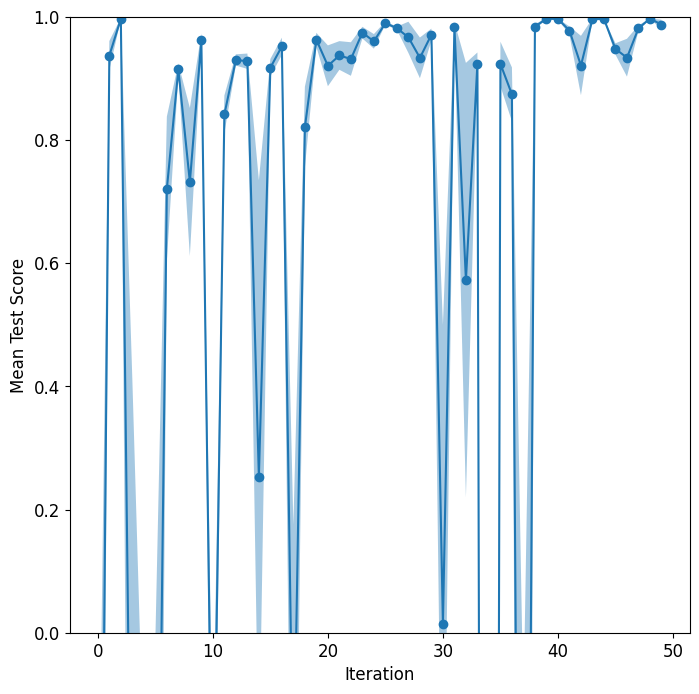

In [14]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])

The Bayesian search explores the search space but ultimately converges on more consistent performing models.

## Model Postprocessing

With the models tuned and the top `pyMAISE.Settings.num_configs_saved` saved, we can now pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. Additionally we can update some hyperparameters after tuning. For MITR we change the number of FNN epochs to 200 since we are only running 5 models. We give the `pyMAISE.PostProcessor` all the scaled data, the model configurations, the new model settings, and the output scaler.

In [15]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"epochs": 200},
    },
    yscaler=yscaler,
)

We can now evaluate the performance of the models using the `pyMAISE.PostProcessor.metrics` function. This returns an ordered table with training and testing performance metrics. By default `pyMAISE.PostProcessor.metrics` evaluates the training and testing $R^2$, mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE) for regression problems. The table is sorted by descending testing $R^2$. We can also add additional metrics, sort by a different metric, or choose the output pyMAISE computes the metrics with. Since all outputs are in watts, we do not need to evaluate each output individually. For further functionality on `pyMAISE.PostProcessor.metrics` refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

In [16]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
23,FNN,"{'Dense_input_0_units': 369, 'Dense_input_0_su...",0.998022,8.808997,148.987985,12.206063,0.997792,9.924809,183.639470,13.551364
22,FNN,"{'Dense_input_0_units': 392, 'Dense_input_0_su...",0.997766,8.367117,163.566414,12.789309,0.997571,9.412539,192.461580,13.873052
21,FNN,"{'Dense_input_0_units': 68, 'Dense_input_0_sub...",0.996893,10.896531,222.138376,14.904307,0.996695,11.562935,254.520415,15.953696
24,FNN,"{'Dense_input_0_units': 89, 'Dense_input_0_sub...",0.996098,11.700476,265.563196,16.296110,0.996079,12.637838,303.815944,17.430317
25,FNN,"{'Dense_input_0_units': 88, 'Dense_input_0_sub...",0.995998,11.105941,285.535842,16.897806,0.995962,12.096698,318.649845,17.850766
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.994681,12.569125,337.055554,18.359073,0.995382,12.798686,321.675740,17.935321
1,Lasso,{'alpha': 0.00012762018205230032},0.994651,12.771498,339.192819,18.417188,0.995348,12.967456,324.269843,18.007494
2,Lasso,{'alpha': 0.00016889180017613136},0.994628,12.855146,340.798718,18.460734,0.995324,13.042295,326.097190,18.058161
3,Lasso,{'alpha': 0.00017948794810275268},0.994621,12.878155,341.283142,18.473850,0.995316,13.062643,326.644283,18.073303
4,Lasso,{'alpha': 0.00022049973451756863},0.994591,12.972281,343.435828,18.532022,0.995284,13.148071,329.061917,18.140064


We can see this data set is very linear with fantastic performance from linear and lasso regression. The FNNs proved to be marginally better performing models over the linear classical models; however, this is at the cost of complexity. K-nearest neighbor, random forest, and decision tree struggled on this data set with all three overfitting.

Using the `pyMAISE.PostProcessor.get_params` function we can see all the top performing (based on test $R^2$) models' hyperparameters.

In [30]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00012762018205230032

Model Types: DT
max_depth: 21
max_features: 6
min_samples_leaf: 5
min_samples_split: 8

Model Types: RF
criterion: squared_error
max_features: 4
min_samples_leaf: 2
min_samples_split: 3
n_estimators: 64

Model Types: KN
leaf_size: 24
n_neighbors: 6
p: 2
weights: distance

Model Types: FNN
Dense_input_0_units: 369
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.5158904806439336
Dense_hidden_num_layers: 0
Adam_learning_rate: 0.0009273054811693854
Dense_hidden_0_units: 187
Dense_hidden_0_sublayer: Dropout_hidden
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.4632972748210508
Dense_hidden_1_units: 59
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.5326295534410079
batch_size: 8



Note parameters such as `Dense_input_0_sublayer_Dropout_0_rate` has a value despite `Dense_input_0_sublayer="None"`. This is a product of the hyperparameter recording of KerasTuner. Even through `Dense_input_0_sublayer_Dropout_0_rate` has a value, there does not exist a `Dense_input_0_sublayer_Dropout_0` layer in the top performing FNN model.

We can use the `pyMAISE.PostProcessor.diagonal_validation_plot` and `pyMAISE.PostProcessor.validation_plot` functions to visualize the performance of these models. Diagonal validation plots show the actual versus predicted outcome. A well performing model follows $y=x$ on this plot. You can choose what outputs to display on the diagonal validation plot; however, since all outputs have the same units we can display all of them. Both functions use the top performing model on test $R^2$ by default.

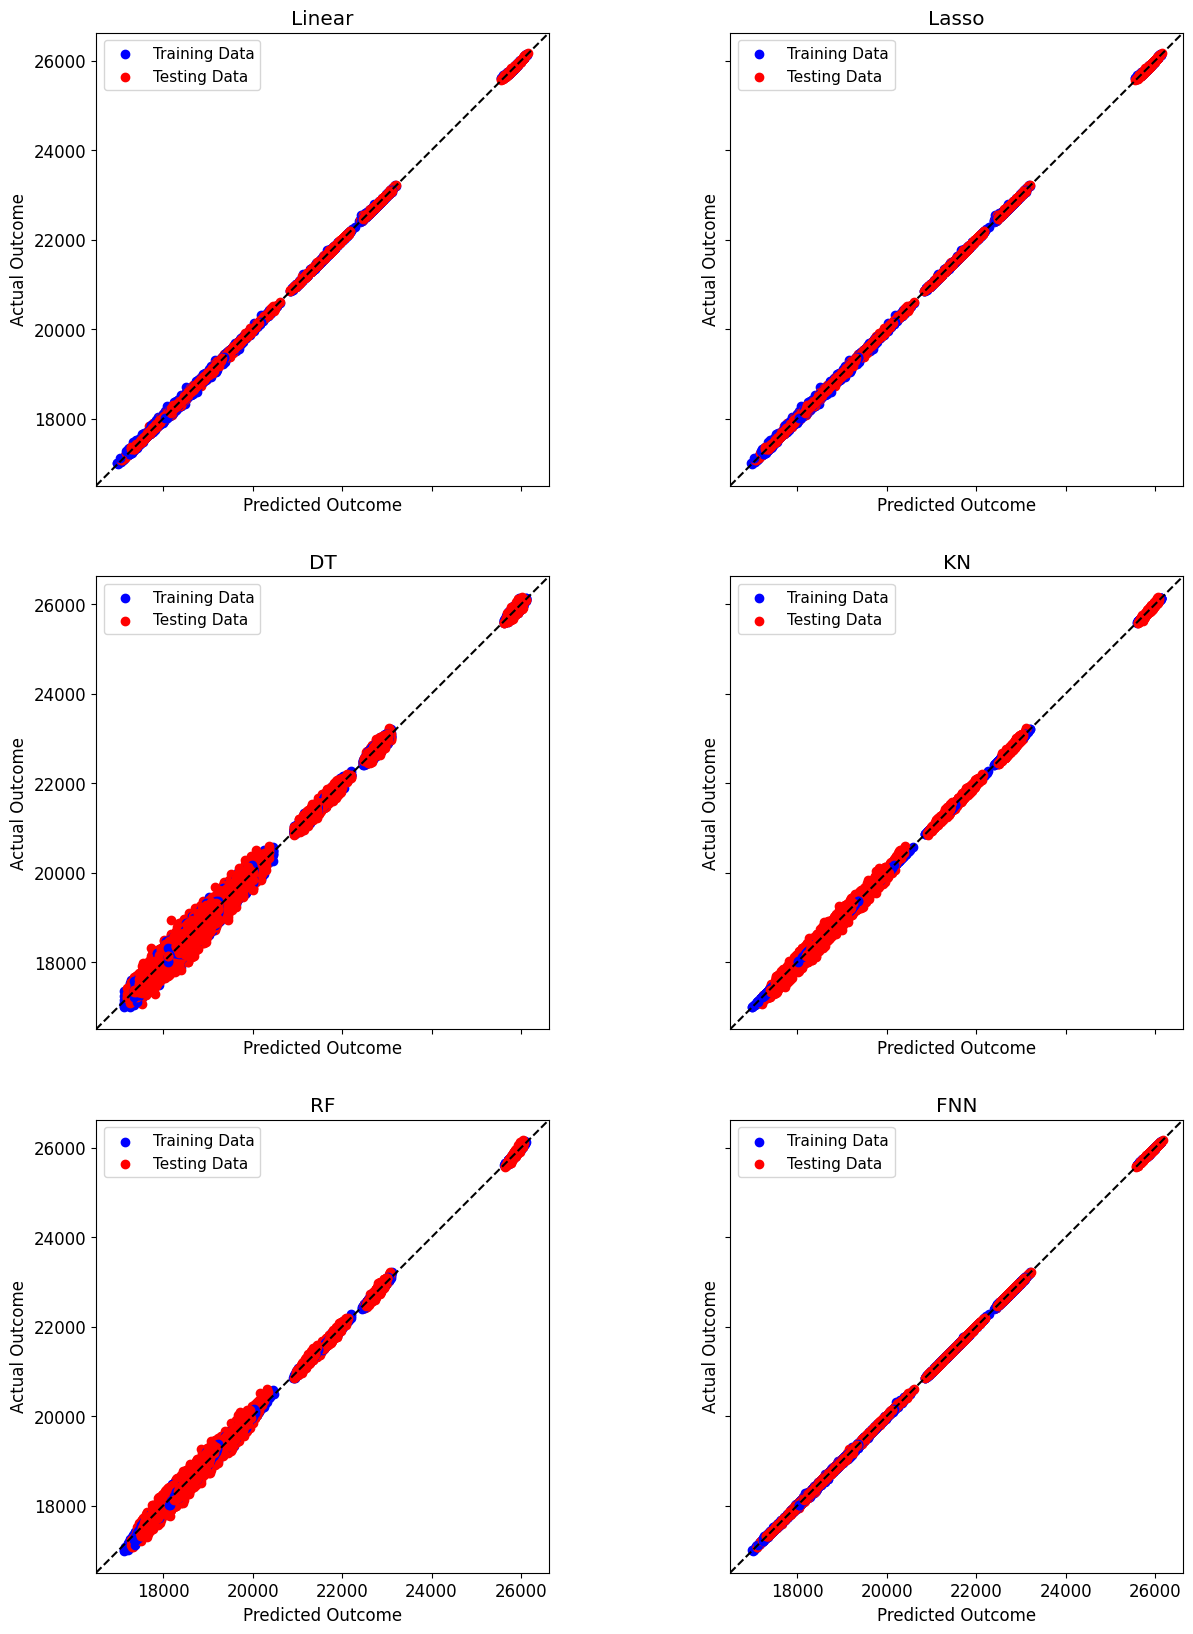

In [20]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

All models display close spread to $y=x$; however, the lack of performance of decision tree, random forest, and k-nearest neighbor is apparent given the larger spread.

Validation plots show the absolute error of the predicted output relative to the actual outputs of the testing data set. The function can evaluate all output or show just what is given in a list. This list can include column positions in the data set or the output names. For the validation plot below only the A-2, B-8, and C-8 fuel elements are shown.

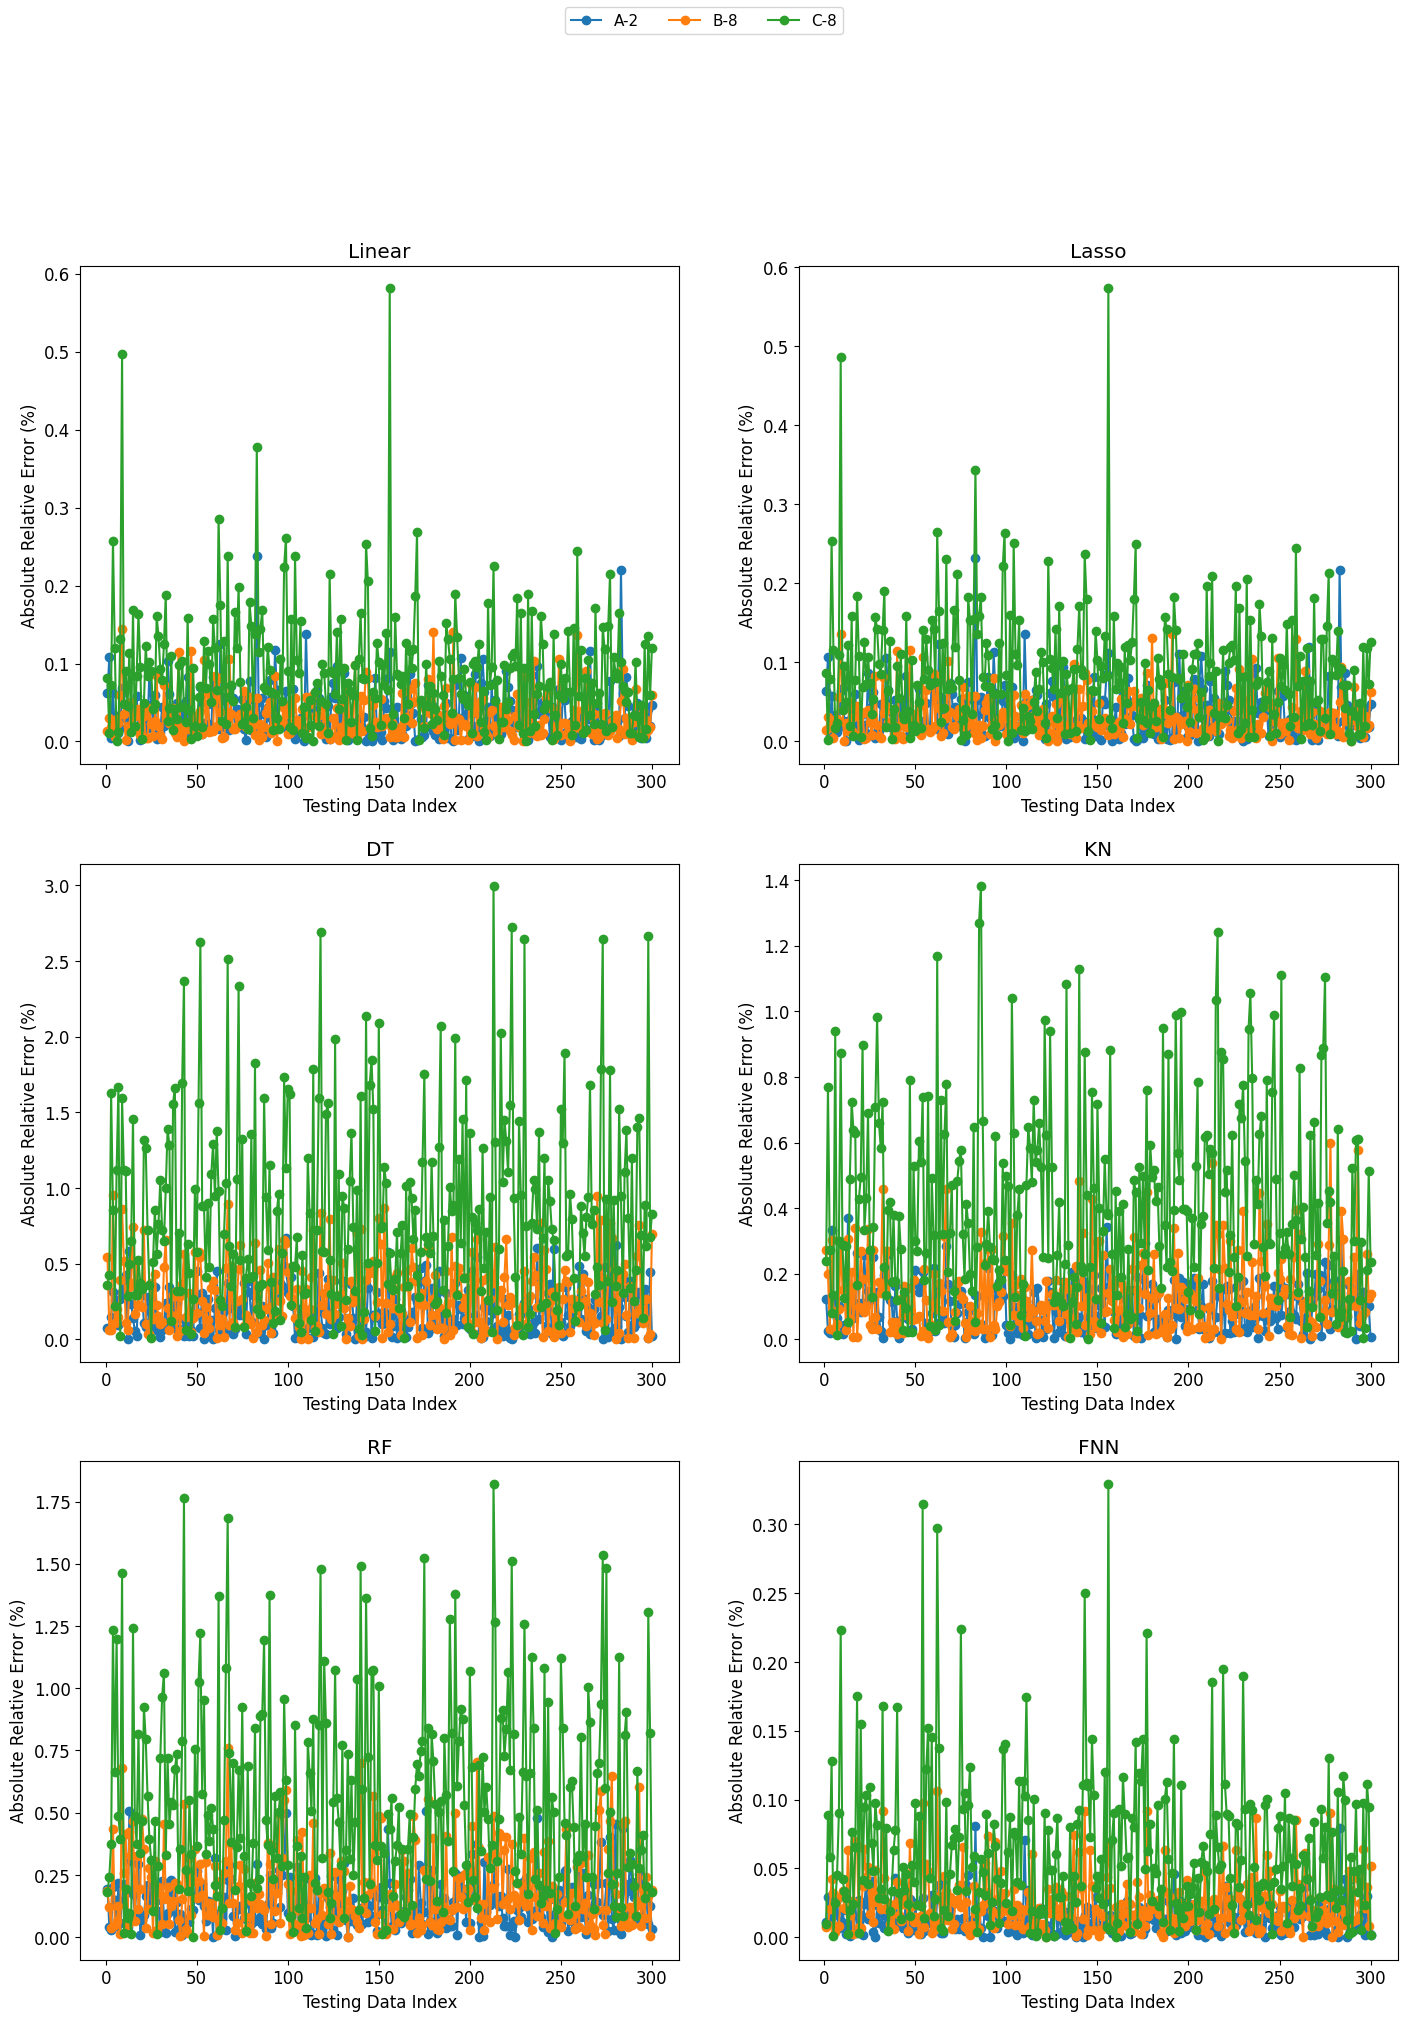

In [21]:
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

y = ["A-2", "B-8", "C-8"]

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y)
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(y, loc="upper center", ncol=4)

The diagonal validation and validation plots agree with the performance metrics. Interestingly all models display an increase in prediction error as we move radially out from the middle of the core.

To further understand the behavior of the top neural network configurations we can plot the learning curve. Here the top neural network learning curve is shown but, similar to the diagonal and validation plot functions, `pyMAISE.PostProcessor.nn_learning_plot` shows the neural network based on the index in `pyMAISE.PostProcessor.metrics` or, if no index is provided, the one with the best test $R^2$.

<Axes: xlabel='Epoch', ylabel='Loss'>

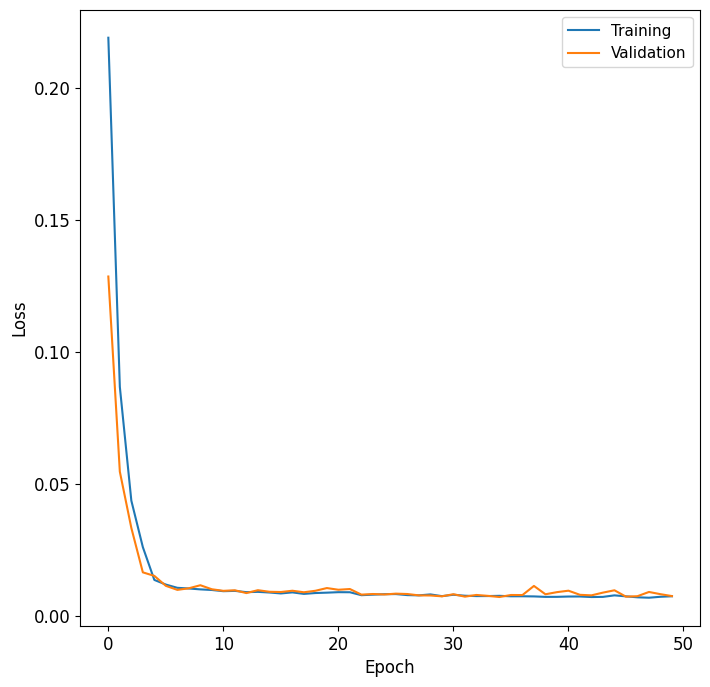

In [22]:
postprocessor.nn_learning_plot()

The FNN is not overfit as the validation curve closely follows the training curve.

Finally, using the best FNN model we can generate a predicted power for each fuel element given the control blade heights. This code block uses the `pyMAISE.PostProcessor.get_model` function to retrieve the top performing model.

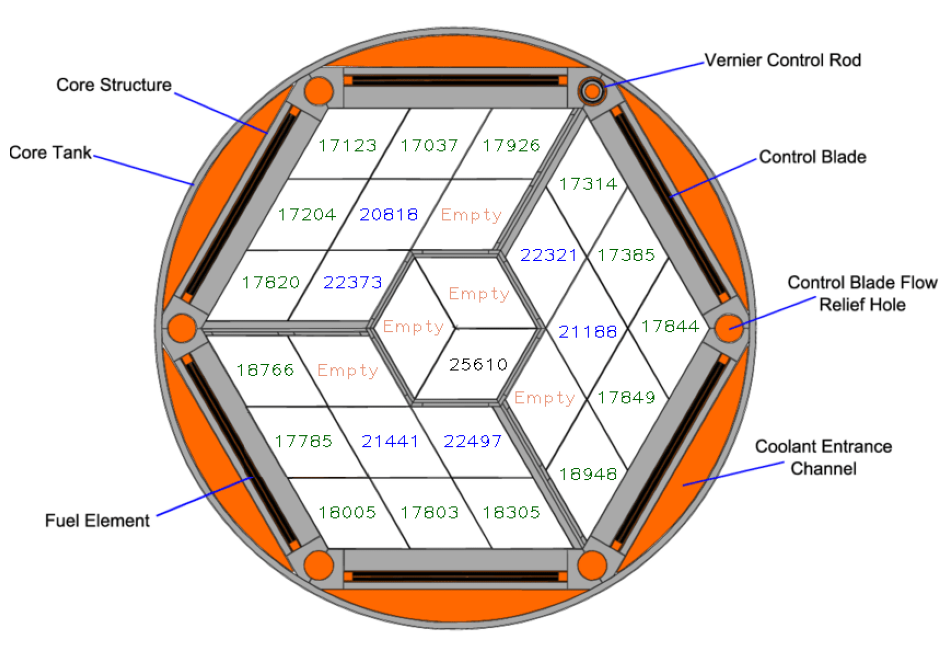

In [23]:
def plot_mitr(model, x, yscaler=None):
    pos=[(400,330), (465,230), (500,300), (395,400), (320,400), (285,255), (318,193),
         (500,165), (535,230), (575,295), (535,360), (500,430), (430,465), (355,465), 
         (280,465), (240,400), (205,335), (210,255), (243,193), (280,130), (355,130), 
         (430,130), (393,193), (460,360), (280,335), (400,265), (340,295)]
    
    Ynn=model.predict(np.array([x,]))
    if yscaler:
        Ynn=yscaler.inverse_transform(Ynn)
    Ynn=Ynn.flatten().tolist()
    
    image = cv2.imread("./supporting/mitr.png")
    for i in range(len(pos)):
        if i==0:
            image=cv2.putText(
                img=np.copy(image), 
                text=str(int(Ynn[i])), 
                org=pos[i], 
                fontFace=1, 
                fontScale=1.1, 
                color=(0,0,0)
            )
        if i in [1,2,3,4,5,6]:
            image=cv2.putText(
                img=np.copy(image), 
                text=str(int(Ynn[i])), 
                org=pos[i], 
                fontFace=1, 
                fontScale=1.1, 
                color=(0,0,255)
            ) 
        if i in list(range(7,22)):
            image=cv2.putText(
                img=np.copy(image), 
                text=str(int(Ynn[i])), 
                org=pos[i], 
                fontFace=1, 
                fontScale=1.1, 
                color=(0, 100, 0)
            ) 
        if i in list(range(22,28)):
            image=cv2.putText(
                img=np.copy(image), 
                text=str('Empty'), 
                org=pos[i], 
                fontFace=1, 
                fontScale=1.1, 
                color=(233, 150, 122)
            )            
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis('off')

x=[0.75266553, 0.90280633, 0.00539489, 0.25308624, 0.57678792, 0.77792903]

plot_mitr(postprocessor.get_model(), x, yscaler)

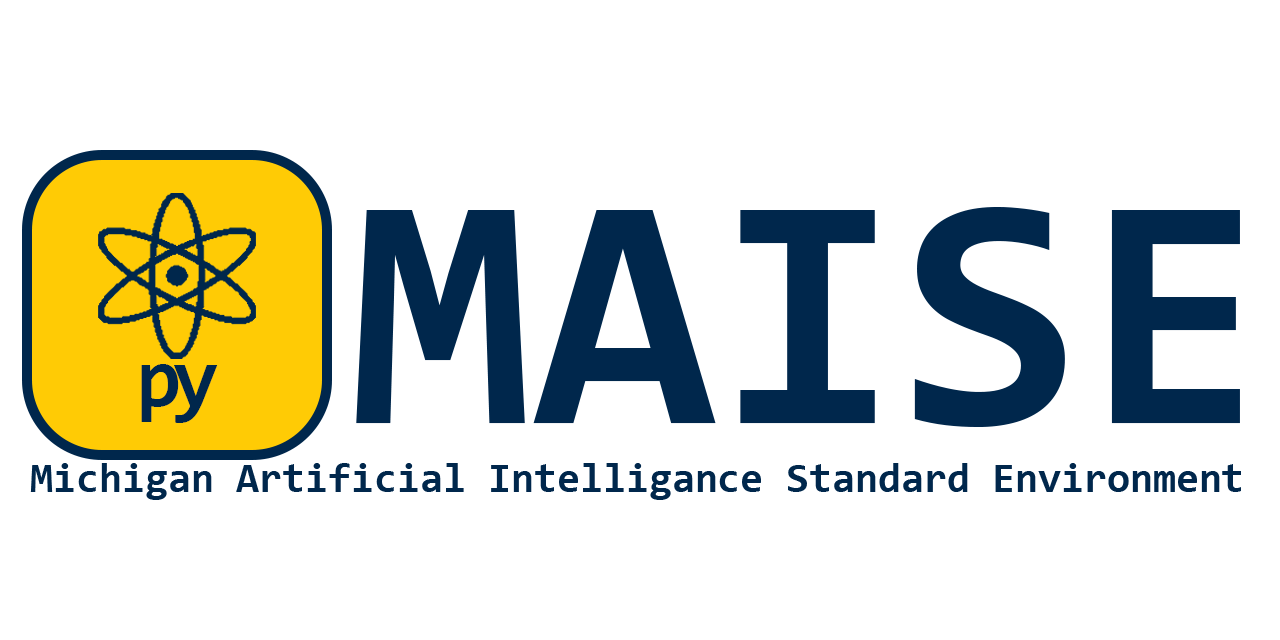